# Movie Recommender System using Collaborative Filtering.

## 1. Introduction:

![Capture](https://user-images.githubusercontent.com/67468718/120515663-5fc7e500-c383-11eb-9286-a1dcbbf509fc.JPG)

Over the last few decades, with the advent of YouTube, Amazon, Netflix and many other Web services, recommendation platforms are becoming much more part of our lives from e commerce, suggesting the customers articles that could be of interest.

In a very general way, Recommendation systems are algorithms program to present related things to users with items being movies to watch, books to read, products to buy or anything else, depending on the industry.
Recommendation systems are very important in some industries because they can produce a large amount of money if they're effective, or if they are a way of standing out dramatically from competitors.
The aim of the recommendation framework is to produce relevant suggestions for the collection of users of objects or products that may be of interest to them. 
Suggestions for Amazon books or Netflix shows are all really world examples of how industry leading systems work. The architecture of such recommendation engines depends on the domain and basic characteristics of the available data.


There are mainly Three types of recommendation engines:
 1. Collaborative filtering.
 2. Content based Filtering.
 3. Hybrid (Combination of Collaborative and Content based Filtering).
 
In this project we'll be working to build a Recommender Engine based on Collaborative Filtering method.

Collaborative filtering Method for recommendation systems is focused entirely on previous experiences documented between users and items in order to generate new recommendations. These interactions are contained in what's called a user item interaction matrix.


## 2. Import all necessary libraries


In [45]:
print('>> Importing Libraries')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#singular value decomposition, which is the exact model that will be using to actually create the recommendation system.
from surprise import Reader, Dataset, SVD #
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate
import os
from collections import defaultdict
from surprise.model_selection import GridSearchCV

plt.style.use('ggplot')
print('>> Libraries Imported!')

>> Importing Libraries
>> Libraries Imported!


## 3. Importing Data

We'll be using open-source Dataset from [groupLens Research](https://movielens.org/)

In [ ]:
# Check Current Directory:
os.getcwd()

In [6]:
# Changing the directory:
os.chdir(r"path/collabrative project")

In [ ]:
#Confirm the directory:
os.getcwd()

In [ ]:
# List files/folders in the cd:
os.listdir()

In [55]:
#let's import the data: ratings.csv
df_new = pd.read_csv('ratings.csv')

In [56]:
# let's check top 5 rows from the dataset:
df_new.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [61]:
# let's look at overview of the dataframe: shape, datatype, ..etc
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [62]:
# let's look at the daraframe shape:
original_shape = df_new.shape
print(f'Original rating shape: {original_shape}')

Original rating shape: (100836, 4)


## 4. Dropping columns.

We won't be using 'timestamp' column when user gave the particular rating. so well drop that column.

In [63]:
#ok, so now let's drop timestamp column:
df_new.drop('timestamp', axis=1, inplace=True)
df_new.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 5. Missing & Duplicate Data:

In [64]:
#First let's have a general view of tracks df:
ratings_missing = pd.concat([df_new.nunique(), df_new.dtypes, df_new.isnull().sum(), 100*df_new.isnull().mean()], axis=1)
ratings_missing.columns = [['unique_count', 'data_type', 'missing_count', 'missing%']]
ratings_missing

,unique_count,data_type,missing_count,missing%
userId,610,int64,0,0.0
movieId,9724,int64,0,0.0
rating,10,float64,0,0.0


Great, As shown above, there's no missing Data.

In [65]:
dup = df_new.duplicated(['movieId', 'userId', 'rating'])
dups = sum(dup) # By considering all columns 

print(f'The number of duplicate rating entries in the data is: {dups}')

The number of duplicate rating entries in the data is: 0


## 6. Exploratory Data Analysis (EDA):

### 3.1 Number of movies/users

In [66]:
n_movies = df_new['movieId'].nunique()
n_users = df_new['userId'].nunique()


print(f'Number of unique movies: {n_movies}')
print(f'Number of unique users: {n_users}')

Number of unique movies: 9724
Number of unique users: 610


### 3.2 Sparsity of the Data

**Sparsity(%)** = (No of missing values/(Total Values)) * 100 --> In simple term, it is the number of missing ratings portion to the total number of ratings possible.

In [67]:
available_ratings = df_new['rating'].count()
total_ratings = n_movies * n_users
missing_ratings = total_ratings - available_ratings

sparsity = (missing_ratings) / (total_ratings) * 100

print(f'Sparsity: {sparsity}')

Sparsity: 98.30003169443864


### 3.3 Ratings Distribution

Text(0.5, 1.0, 'Rating Distribution')

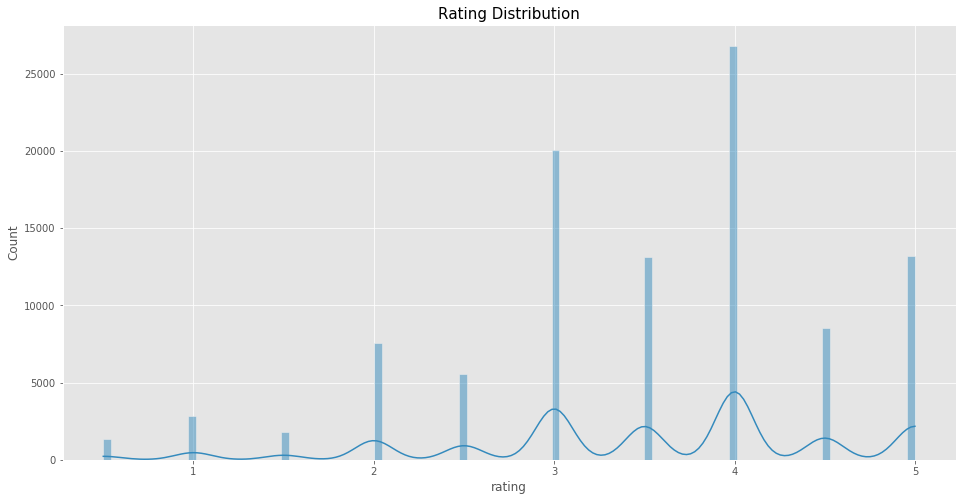

In [68]:
f, ax = plt.subplots(figsize = (16,8))
ax = sns.histplot(x=df_new['rating'], kde=True)
ax.set_title('Rating Distribution', fontsize=15)

### 3.4 Number of rated movies per user

In [69]:
no_rated_movies_per_user = df_new.groupby('userId')['rating'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'No of rated Movies per User')

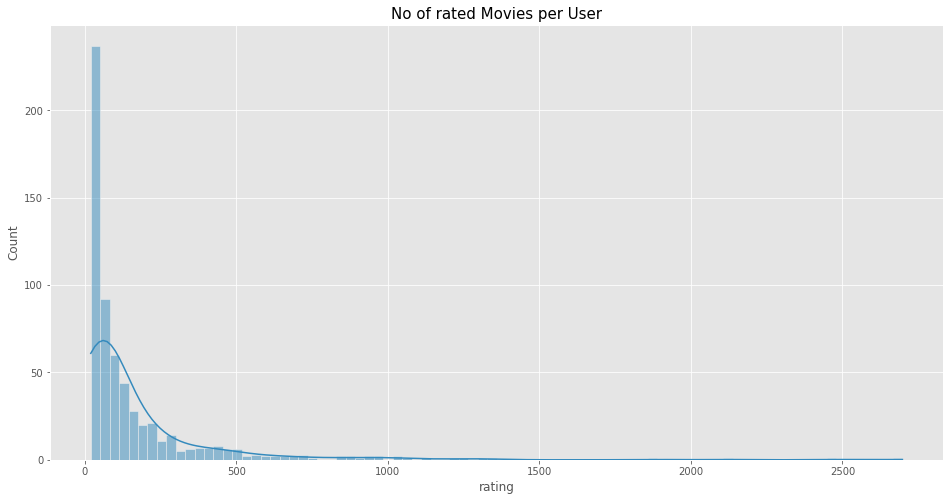

In [70]:
f, ax = plt.subplots(figsize = (16,8))
ax = sns.histplot(x=no_rated_movies_per_user, kde=True)
ax.set_title('No of rated Movies per User', fontsize=15)

### 3.5 Number ratings per Movie

In [71]:
no_of_ratings_per_movie = df_new.groupby('movieId')['rating'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'No of ratings per Movie')

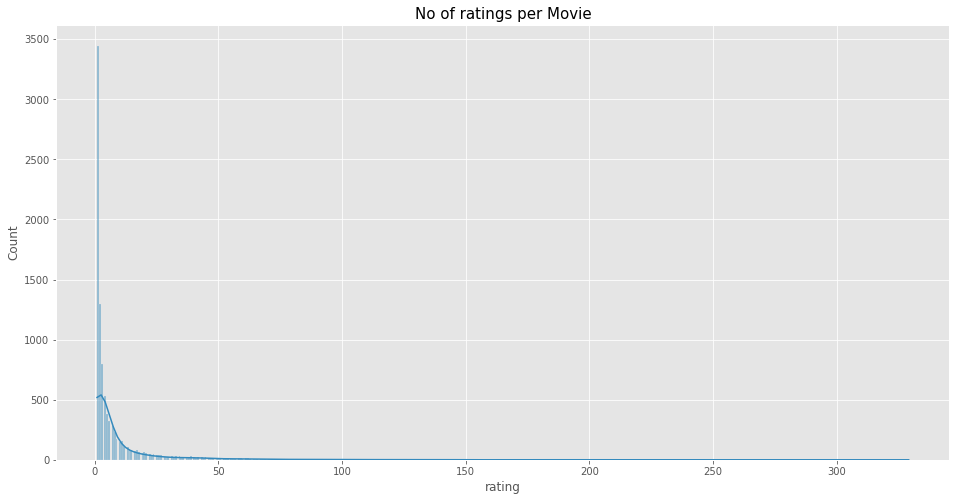

In [72]:
f, ax = plt.subplots(figsize = (16,8))
ax = sns.histplot(x=no_of_ratings_per_movie, kde=True)
ax.set_title('No of ratings per Movie', fontsize=15)

## 4. Dimensionality Reduction

To reduce the dimensionality of the dataset, we'll filter out rarely rated movies and rarely rating users

### 4.1 Filter movies with less than 3 ratings

In [77]:
filter_movies = df_new['movieId'].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()

### 4.2 Filter users with less than 3 movies rated

In [78]:
filter_users = df_new['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()

### 4.3 Remove rarely rated movies and rarely rating users

In [79]:
print(f'Original Shape: {df_new.shape}')

Original Shape: (100836, 3)


In [81]:
df_new = df_new[(df_new['movieId'].isin(filter_movies)) & (df_new['userId'].isin(filter_users))]
print(f'New Shape: {df_new.shape}')

New Shape: (92394, 3)


## 5. Create Training and Test Sets

### 5.1 Columns used for Training

In [82]:
cols = ['userId', 'movieId', 'rating']

### 5.2 create Suprise Dataset

In [83]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[cols], reader)

### 5.3 Create Train-set and Prediction-set

In [84]:
trainset = data.build_full_trainset()
# antiset: is the combination of all users on movies that do not have a training yet.
antiset = trainset.build_anti_testset()

## 6. Creating and training the Model

### 6.1 Creating the Model

We have picked SVD (Singular Value Decomposition) as good matrix factorization systems.

Interaction matrix = A x B x c

In [86]:
algo = SVD(n_epochs = 10, 
           lr_all = 0.005,
           reg_all = 0.4,
           verbose=True)




### 6.2 Trainging the Model

**Mean Absolute Error (MAE):**  measures the avregae magnitude of the errors in a set of predictions, without their direction.

**Root Mean Squared Error (RMSE):** is the square root of the average of squared differences between predictions and actual observations.
    
    

In [87]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print('>>Training is Done!!!')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 5 split(s

## 7. Tune algorithm parameters with GridSearchCV

The cross_validate() function reports accuracy metric over a cross-validation procedure for a given set of parameters. If you want to know which parameter combination yields the best results, the GridSearchCV class comes to the rescue. Given a dict of parameters, this class exhaustively tries all the combinations of parameters and reports the best parameters for any accuracy measure (averaged over the different splits). It is heavily inspired from scikit-learn’s GridSearchCV.

In [47]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8827578126576427
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Once fit() has been called, the best_estimator attribute gives us an algorithm instance with the optimal set of parameters:

In [49]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

## 8. Predictions

### 8.1 Predict ratings for all pairs (user, items) that are NOT in the training set.

In [88]:
predictions = algo.test(antiset)
print(type(predictions))

<class 'list'>


In [89]:
predictions[0:5]

[Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=4.662385640933375, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.529119856267723, est=4.413083567867726, details={'was_impossible': False}),
 Prediction(uid=1, iid=6874, r_ui=3.529119856267723, est=4.416094632798852, details={'was_impossible': False}),
 Prediction(uid=1, iid=8798, r_ui=3.529119856267723, est=4.216674603044155, details={'was_impossible': False}),
 Prediction(uid=1, iid=46970, r_ui=3.529119856267723, est=3.9571765894040243, details={'was_impossible': False})]

### 8.2 Recommending top 3 movies based on predictions

In [90]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [91]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2273068,564,3869,3.52912,3.529119,{'was_impossible': False},144,26,6.615461e-07
1661462,412,3699,3.52912,3.529119,{'was_impossible': False},100,13,8.112120e-07
1349592,335,86882,3.52912,3.529119,{'was_impossible': False},28,25,9.164947e-07
1122213,278,2560,3.52912,3.529121,{'was_impossible': False},20,8,9.953519e-07
52387,13,2970,3.52912,3.529121,{'was_impossible': False},31,4,1.395006e-06
2346728,582,68319,3.52912,3.529118,{'was_impossible': False},56,26,1.755531e-06
832090,206,2456,3.52912,3.529122,{'was_impossible': False},25,9,1.825538e-06
1077081,267,3835,3.52912,3.529122,{'was_impossible': False},57,6,1.872171e-06
1151234,285,79428,3.52912,3.529118,{'was_impossible': False},35,7,1.904620e-06
1576092,391,3230,3.52912,3.529118,{'was_impossible': False},365,4,2.188192e-06


The above are the best predictions, and they are not lucky guesses , they are not really small, meaning that significant number of users have rated the target movie.

In [92]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1782306,442,3593,3.52912,1.690740,{'was_impossible': False},20,19,1.838380
1239475,308,1882,3.52912,1.687170,{'was_impossible': False},112,33,1.841950
10637,3,3593,3.52912,1.684889,{'was_impossible': False},30,19,1.844231
8750,3,2701,3.52912,1.682256,{'was_impossible': False},30,53,1.846863
1780330,442,374,3.52912,1.674636,{'was_impossible': False},20,25,1.854484
9431,3,1562,3.52912,1.651586,{'was_impossible': False},30,42,1.877534
615382,153,1882,3.52912,1.632009,{'was_impossible': False},164,33,1.897110
558349,139,1882,3.52912,1.631741,{'was_impossible': False},194,33,1.897379
8980,3,1882,3.52912,1.573623,{'was_impossible': False},30,33,1.955497
1780659,442,1882,3.52912,1.482775,{'was_impossible': False},20,33,2.046345


The worst predictions look pretty surprise. Let’s look in more details of the last one "1882". The movie was rated by 19 users, user “442” rated 3.5, our Baseline Only algorithm predicts this user would rate 1.48.

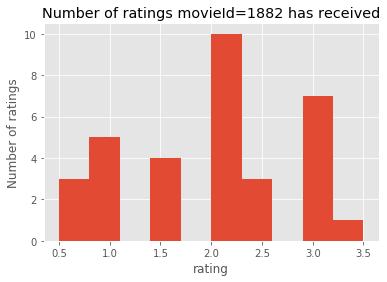

In [94]:
df_new.loc[df_new['movieId'] == 1882]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movieId=1882 has received')
plt.show();

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))